<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
from google.colab import files
import yfinance as yf

In [7]:
stocklist = ['GFI', 'FSR']
stocks = [i + '.JO' for i in stocklist]
stocks

['GFI.JO', 'FSR.JO']

In [8]:
start = "2013-03-01"
end = "2024-02-28"


df = yf.download(['GFI.JO', 'FSR.JO'], start=start, end=end)

df.head()

/tmp/ipython-input-2495352864.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['GFI.JO', 'FSR.JO'], start=start, end=end)
[*********************100%***********************]  2 of 2 completed


Price             Close                      High                       Low  \
Ticker           FSR.JO       GFI.JO       FSR.JO       GFI.JO       FSR.JO   
Date                                                                          
2013-03-01  3121.474365  7431.280762  3132.409467  7503.099851  3062.822458   
2013-03-04  3064.810547  7250.466797  3126.444752  7385.141125  3032.005244   
2013-03-05  3201.002197  7257.450195  3201.002197  7283.387474  3083.698390   
2013-03-06  3107.556396  6928.246094  3220.883789  7299.348692  3105.568197   
2013-03-07  3114.515625  7453.974121  3156.267829  7503.853498  3095.627723   

Price                           Open                 Volume            
Ticker           GFI.JO       FSR.JO       GFI.JO    FSR.JO    GFI.JO  
Date                                                                   
2013-03-01  7338.514438  3084.692661  7465.195332  12379894   5930842  
2013-03-04  7250.466797  3126.444752  7370.177311  14174847   4128626  
2013-03-05  7217.546689  3100.598091  7262.438134  16391688   5666832  
2013-03-06  6928.246094  3202.989990  7258.447599  18189945   6130247  
2013-03-07  7237.497624  3132.409427  7282.389064  18272095  10489933

In [9]:
Close = df['Close']
Close.head()

Ticker,FSR.JO,GFI.JO
Date,,
2013-03-01,3121.474365,7431.280762
2013-03-04,3064.810547,7250.466797
2013-03-05,3201.002197,7257.450195
2013-03-06,3107.556396,6928.246094
2013-03-07,3114.515625,7453.974121


In [10]:
gfi_close = Close['GFI.JO']

gfi_close = pd.DataFrame(gfi_close)
gfi_close['Target'] = (gfi_close['GFI.JO'].shift(-1) > gfi_close['GFI.JO']).astype(int)
gfi_close.dropna(inplace=True)

display(gfi_close.head())

,GFI.JO,Target
Date,,
2013-03-01,7431.280762,0
2013-03-04,7250.466797,1
2013-03-05,7257.450195,0
2013-03-06,6928.246094,1
2013-03-07,7453.974121,0


In [12]:
gfi_close_data = Close['GFI.JO']

X_train, X_test, y_train, y_test = train_test_split(gfi_close_data.index.values.reshape(-1, 1), gfi_close_data.values, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (2237, 1) (2237,)
Testing set shape: (560, 1) (560,)


In [13]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("Scaled Training Features (first 5 rows):\n", X_train_scaled[:5])
print("\nScaled Testing Features (first 5 rows):\n", X_test_scaled[:5])

Scaled Training Features (first 5 rows):
 [[0.0550573 ]
 [0.68784255]
 [0.51619332]
 [0.73841555]
 [0.08320877]]

Scaled Testing Features (first 5 rows):
 [[0.73368211]
 [0.42376682]
 [0.25087195]
 [0.92775286]
 [0.75336323]]


In [14]:
# Initialize and train the XGBoost Regressor model
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
xgbr.fit(X_train_scaled, y_train)

print("XGBoost model training complete.")

XGBoost model training complete.


In [15]:

y_pred = xgbr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse}")

Mean Squared Error on the test set: 426119.21835350385


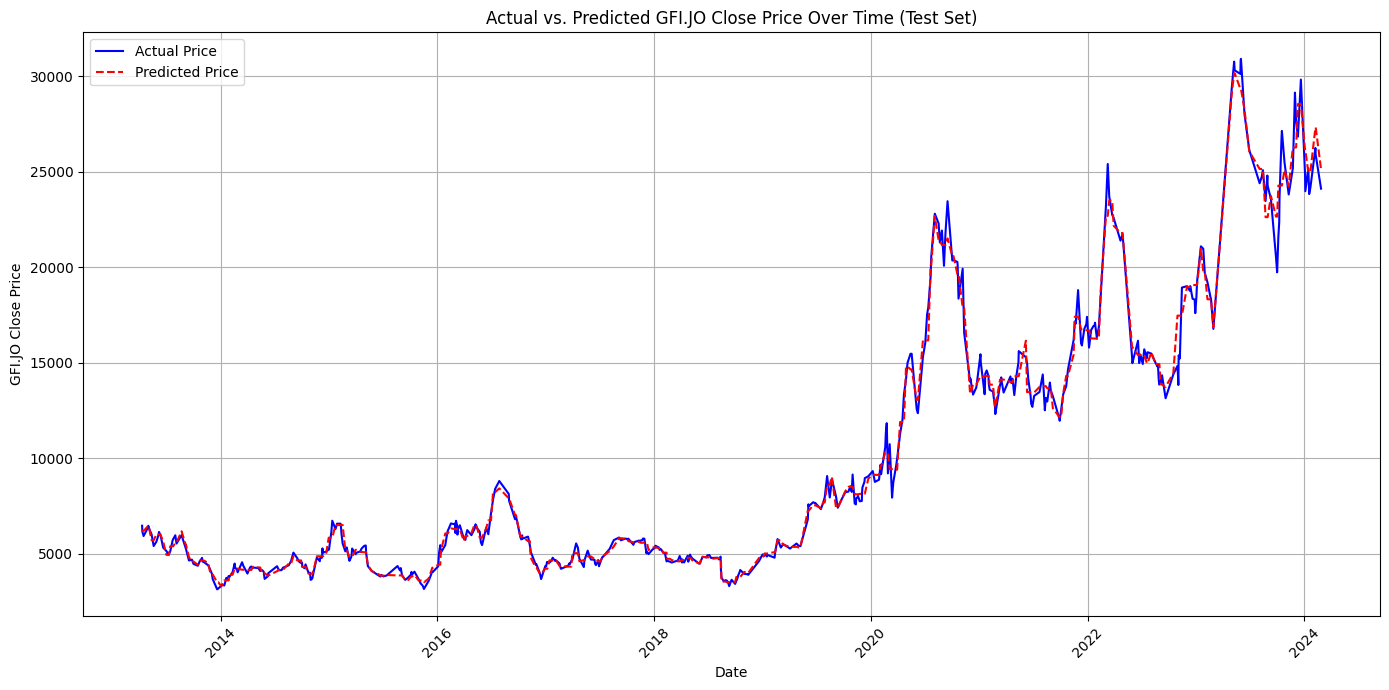

In [20]:
dates = gfi_close_data.index
values = gfi_close_data.values

dates_train, test_dates, y_train_split, y_test_split = train_test_split(
    dates, values, test_size=0.2, random_state=42
)


original_test_dates_numerical = scaler.inverse_transform(X_test_scaled)

test_dates = original_test_dates_numerical.flatten().astype('datetime64[ns]')


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Date': test_dates})

results_df.sort_values(by='Date', inplace=True)


plt.figure(figsize=(14, 7))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual Price', color='blue')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted Price', color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("GFI.JO Close Price")
plt.title("Actual vs. Predicted GFI.JO Close Price Over Time (Test Set)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()